In [306]:
import pandas as pd
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import torch.optim as optim
from plotnine import *
from sklearn.base import BaseEstimator, TransformerMixin

In [307]:
# Import Data
folder_path = "data/crypto"
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = []
for file in all_files:
    df = pd.read_csv(file, usecols=["Symbol", "Date", "Close"])
    dfs.append(df)

# Combine all files
securities = pd.concat(dfs, ignore_index=True)

# Pivot to wide format
sec_wide = securities.pivot(index="Date", columns="Symbol", values="Close")

# Remove the "Symbol" column name
sec_wide.columns.name = None

# Remove unwanted columns safely
remove_cols = ['WBTC', 'USDT', 'USDC']
sec_wide = sec_wide.drop(columns=remove_cols)

# Parse Date as datetime
sec_wide.index = pd.to_datetime(sec_wide.index)

# Remove rows with any NaN values
sec_wide = sec_wide.dropna()

# Optional: reset index so Date becomes a column
sec_wide = sec_wide.reset_index()

print(sec_wide.head())

                 Date       AAVE       ADA      ATOM        BNB           BTC  \
0 2020-10-05 23:59:59  53.219243  0.097544  5.382198  28.659104  10793.339428   
1 2020-10-06 23:59:59  42.401599  0.092808  4.732915  27.714528  10604.405889   
2 2020-10-07 23:59:59  40.083976  0.093800  4.886457  27.704836  10668.968955   
3 2020-10-08 23:59:59  43.764463  0.096152  5.045788  27.705311  10915.685731   
4 2020-10-09 23:59:59  46.817744  0.101925  5.157042  28.445031  11064.457592   

        CRO      DOGE       DOT       EOS  ...       LINK        LTC  \
0  0.150009  0.002612  4.172700  2.529068  ...   9.623703  46.363226   
1  0.147198  0.002611  3.756162  2.693054  ...   8.779272  45.985530   
2  0.147583  0.002595  3.858798  2.646043  ...   8.957850  46.660479   
3  0.150626  0.002596  4.102642  2.609671  ...   9.508818  47.218381   
4  0.152428  0.002653  4.262468  2.645295  ...  10.346902  47.832955   

      MIOTA       SOL       TRX       UNI       XEM       XLM         XMR  \
0  

In [308]:
class MeanScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        return self

    def transform(self, X):
        X = np.asarray(X)
        return X / self.mean_

    def inverse_transform(self, X_scaled):
        X_scaled = np.asarray(X_scaled)
        return X_scaled * self.mean_

In [309]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [310]:
# Make target and features
base = 'BTC'
X = sec_wide.drop(columns=['Date', base])
y = sec_wide[base].values.reshape(-1, 1)

# Scale data
scalar_X = MeanScaler()
scalar_y = MeanScaler()

X_scaled = scalar_X.fit_transform(X.values)
y_scaled = scalar_y.fit_transform(y)

# Convert to torch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

# Train-test split
split_percent = 0.9
split_idx = int(split_percent * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create DataLoaders
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [311]:
# Model
class LinearRegressionModel(nn.Module):
    def __init__ (self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False) # just a linear combination of inputs

    def forward(self, x):
        return self.linear(x) # no activation function, just linear
    
model = LinearRegressionModel(X.shape[1]).to(device)

In [325]:
# Training Setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [326]:
# Training Loop
epochs = 1000
# Define fractions per epoch (repeat if epochs > 9)
fractions = [1.0]*250 + [0.5]*250 + [0.25]*500
if epochs > len(fractions):
    # Extend the last fraction for remaining epochs
    fractions += [fractions[-1]]*(epochs - len(fractions))

# Put model on device
model.to(device)

for epoch in range(epochs):
    # Determine fraction for this epoch
    frac = fractions[epoch]
    n_samples = int(len(train_dataset) * frac)
    
    # Randomly select indices
    indices = np.random.choice(len(train_dataset), n_samples, replace=False)
    sampler = SubsetRandomSampler(indices)
    
    # Create a DataLoader for this epoch
    train_loader_epoch = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    
    # Training loop for this epoch
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader_epoch:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= n_samples  # average over sampled dataset
    
    # Evaluate on test set every 10 epochs
    if (epoch+1) % 50 == 0 or (epoch == 0):
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(test_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{epochs}], fraction={frac}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/1000], fraction=1.0, Train Loss: 0.0038, Test Loss: 0.0158
Epoch [50/1000], fraction=1.0, Train Loss: 0.0043, Test Loss: 0.0088
Epoch [100/1000], fraction=1.0, Train Loss: 0.0040, Test Loss: 0.0135
Epoch [150/1000], fraction=1.0, Train Loss: 0.0040, Test Loss: 0.0143
Epoch [200/1000], fraction=1.0, Train Loss: 0.0038, Test Loss: 0.0049
Epoch [250/1000], fraction=1.0, Train Loss: 0.0040, Test Loss: 0.0108
Epoch [300/1000], fraction=0.5, Train Loss: 0.0038, Test Loss: 0.0064
Epoch [350/1000], fraction=0.5, Train Loss: 0.0040, Test Loss: 0.0118
Epoch [400/1000], fraction=0.5, Train Loss: 0.0040, Test Loss: 0.0099
Epoch [450/1000], fraction=0.5, Train Loss: 0.0050, Test Loss: 0.0061
Epoch [500/1000], fraction=0.5, Train Loss: 0.0041, Test Loss: 0.0148
Epoch [550/1000], fraction=0.25, Train Loss: 0.0034, Test Loss: 0.0057
Epoch [600/1000], fraction=0.25, Train Loss: 0.0038, Test Loss: 0.0080
Epoch [650/1000], fraction=0.25, Train Loss: 0.0065, Test Loss: 0.0072
Epoch [700/1000], fr

In [327]:
# Extract Weights
raw_weights = model.cpu().linear.weight.detach().numpy().flatten()

# Rescale weights
weights = raw_weights * scalar_y.mean_ / scalar_X.mean_
print("Weights unscaled: ", weights)

Weights unscaled:  [[ 4.54027405e-01  8.64527166e+03 -2.94033405e+02 -2.97452199e+01
   3.78494640e+04 -3.55064205e+04  7.43014374e+01 -3.06838172e+03
   3.96845201e+00 -5.73739641e+01  1.62624190e+02  1.58134158e+03
  -1.46197848e+02  1.00415260e+05  2.54540982e+02  8.71981314e+02
   5.79890941e+03  4.64287872e+01 -1.75685306e+03]]


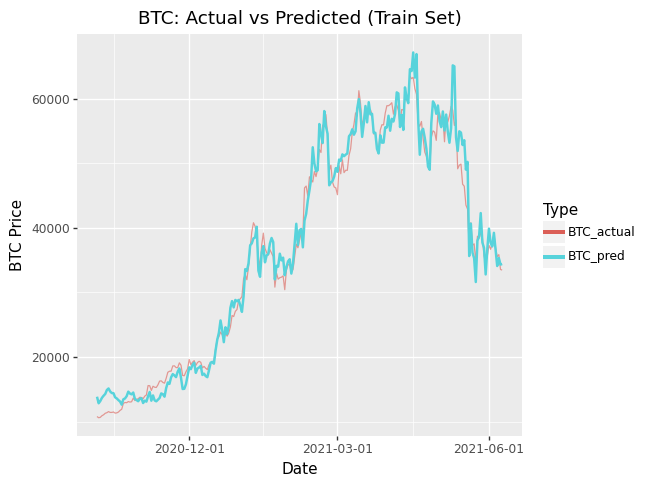

In [328]:
# Select only feature columns (exclude Date and target/base)
X_cols = sec_wide.drop(columns=['Date', base])

# Convert to NumPy for elementwise multiplication
weighted_sum = (X_cols.values * weights).sum(axis=1)

# Put into DataFrame
portfolio = pd.DataFrame({
    'Date': sec_wide['Date'],
    'Weighted_Sum': weighted_sum
})

# Plot
df_plot_train = pd.DataFrame({
    'Date': sec_wide['Date'][:split_idx].reset_index(drop=True),
    'BTC_actual': sec_wide[base].iloc[:split_idx].to_numpy().flatten(),
    'BTC_pred': portfolio['Weighted_Sum'].iloc[:split_idx].to_numpy().flatten()
})

# Melt for plotting
df_melt_train = df_plot_train.melt(
    id_vars='Date',
    value_vars=['BTC_actual', 'BTC_pred'],
    var_name='Type',
    value_name='BTC'
)

# Plot with legend
p_train = (
    ggplot(df_melt_train, aes(x='Date', y='BTC', color='Type')) +
    geom_line(df_melt_train[df_melt_train['Type'] == 'BTC_actual'], alpha=0.6) +
    geom_line(df_melt_train[df_melt_train['Type'] == 'BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Train Set)') +
    xlab('Date') +
    ylab('BTC Price')
)

p_train.draw()



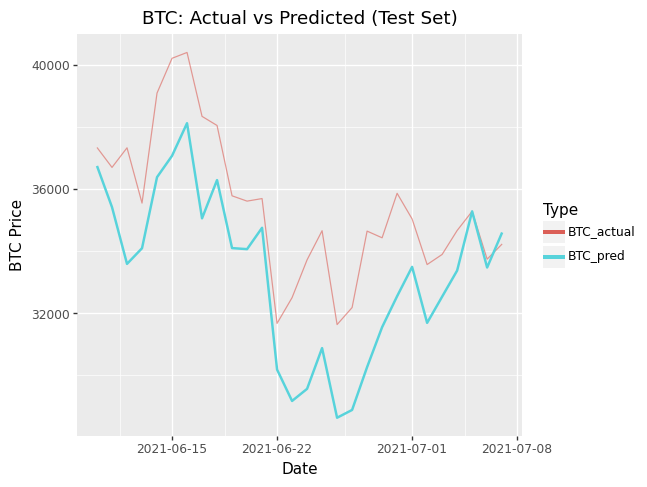

In [329]:
# Compute weighted portfolio again (if not already done)
X_cols = sec_wide.drop(columns=['Date', base])
weighted_sum = (X_cols.values * weights).sum(axis=1)

portfolio = pd.DataFrame({
    'Date': sec_wide['Date'],
    'Weighted_Sum': weighted_sum
})

# Plot test set
df_plot_test = pd.DataFrame({
    'Date': sec_wide['Date'].iloc[split_idx:].reset_index(drop=True),
    'BTC_actual': sec_wide[base].iloc[split_idx:].to_numpy().flatten(),
    'BTC_pred': portfolio['Weighted_Sum'].iloc[split_idx:].to_numpy().flatten()
})

# Melt for plotting
df_melt_test = df_plot_test.melt(
    id_vars='Date',
    value_vars=['BTC_actual', 'BTC_pred'],
    var_name='Type',
    value_name='BTC'
)

# Plot with legend
p_test = (
    ggplot(df_melt_test, aes(x='Date', y='BTC', color='Type')) +
    geom_line(df_melt_test[df_melt_test['Type'] == 'BTC_actual'], alpha=0.6) +
    geom_line(df_melt_test[df_melt_test['Type'] == 'BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Test Set)') +
    xlab('Date') +
    ylab('BTC Price')
)

p_test.draw()


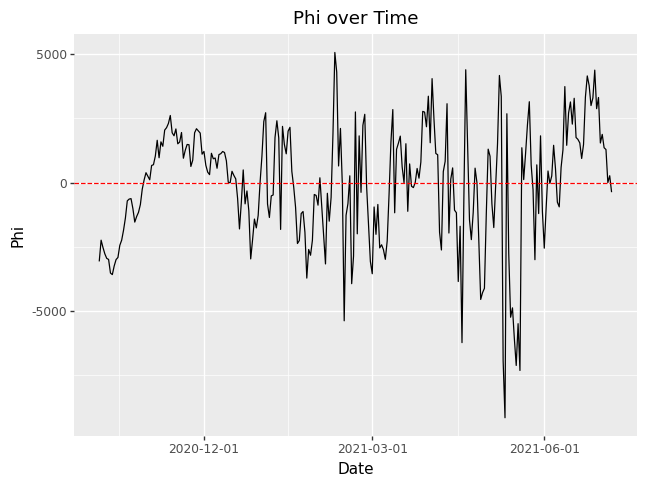

In [330]:
# Find PHI

phi = sec_wide[base].subtract(weighted_sum, axis=0)

phi_df = pd.DataFrame({
    'Date': sec_wide['Date'],
    'phi': phi
})

p_phi = (
    ggplot(phi_df, aes(x='Date', y='phi')) +
    geom_line() +
    ggtitle('Phi over Time') +
    xlab('Date') +
    ylab('Phi') +
    geom_hline(yintercept=0, linetype='dashed', color='red')
)
p_phi.draw()

In [331]:
# Find AR(1) parameters
import statsmodels.api as sm

frac = 1/4
print(round(len(phi)*frac))

phi_tail = phi[round(len(train_dataset)*(1-frac)):split_idx] # use phi from end of training data

model_ar = sm.tsa.ARIMA(phi_tail, order=(1,0,0))
result = model_ar.fit()
print(result.summary())

gamma = result.params['ar.L1']
mu = result.params['const']
sigma2 = result.params['sigma2']

# TODO: Make backtest

69
                               SARIMAX Results                                
Dep. Variable:                    BTC   No. Observations:                   62
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -577.650
Date:                Sat, 18 Oct 2025   AIC                           1161.300
Time:                        21:19:29   BIC                           1167.681
Sample:                             0   HQIC                          1163.806
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1084.2144    644.188     -1.683      0.092   -2346.801     178.372
ar.L1          0.4186      0.093      4.516      0.000       0.237       0.600
sigma2      7.292e+06   1.36e+06      5.375      